In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from typing import Dict
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple, get_data

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
start_date = '20190101'
end_date='20191231'
periods=[5,10,20,40,80,160,320]
breakout_periods=[20]
carver_periods=[20,40,60]
roc_periods = [5,10,20,40]
s='20180501'

In [11]:
def inds(sym):
    params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s, periods=periods),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=breakout_periods),
    'carver': calibrate_multiple(sym, carver, start_date=s, adjustment=40, periods=carver_periods),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=roc_periods),
    'roca': calibrate_multiple(sym, roca, start_date=s, periods=periods),
}
    return {
    #'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    #'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=breakout_periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=carver_periods),
    #'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=roc_periods),
    #'roca': simulate(params['roca'], sym, roca, start_date=start_date, end_date=end_date, periods=periods),
}

In [12]:
def binarize(series):
    df = pd.DataFrame()
    df['long'] = (series > 0) * 1
    df['short'] = (series < 0) * -1
    df['out'] = (series == 0) * 0
    df['signal'] = df.sum(axis=1)
    return df['signal']

In [13]:
def combine(inds: Dict[str, pd.DataFrame]):
    df_in = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df_out = pd.DataFrame({name: binarize(df_in[name]) for name in df_in.columns})
    df_out['forecast'] = df_out.mean(axis=1).round()
    #df_out['forecast'] = df_out.mean(axis=1).apply(np.floor)
    df_out[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    return df_out

In [14]:
returns = pd.DataFrame()
stats = pd.DataFrame()
for asset in ['NQ', 'ES',]:
    out = summary(combine(inds(asset)), slip=1.5, threshold=0)
    returns[asset] = out.returns[0]
    stats[asset] = out.stats[0]
returns = returns.dropna()

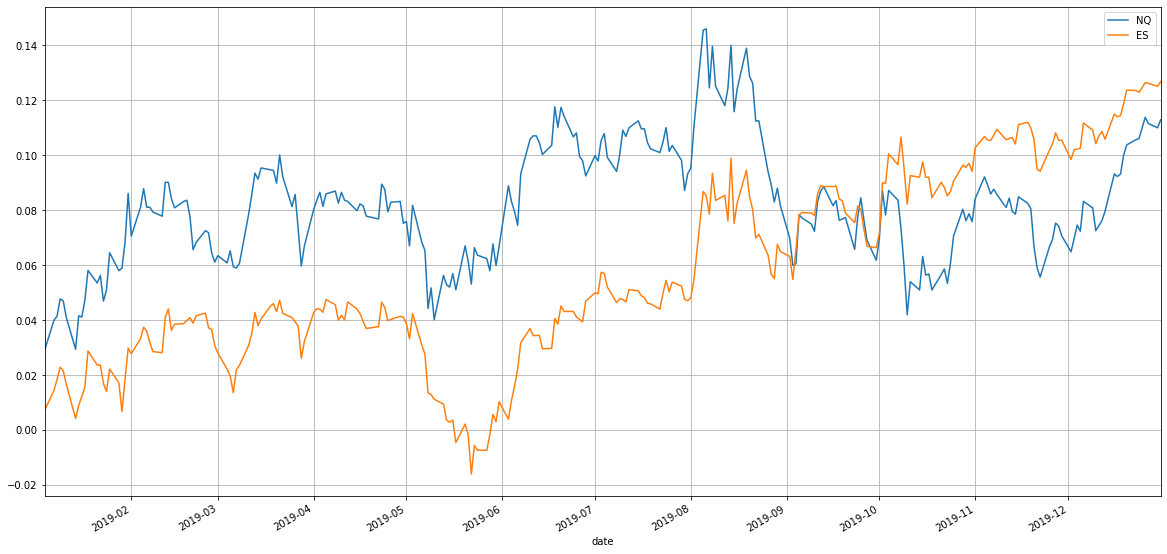

In [15]:
np.log(returns+1).cumsum().plot(figsize=(20, 10), grid=True);

In [16]:
returns.corr()

,NQ,ES
NQ,1.000000,0.762294
ES,0.762294,1.000000


In [17]:
returns['combined'] = returns.mean(axis=1)

In [18]:
perf_stats(returns['combined'])

Annual return          0.126273
Cumulative returns     0.128401
Annual volatility      0.110579
Sharpe ratio           1.130553
Calmar ratio           2.096351
Stability              0.595944
Max drawdown          -0.060235
Omega ratio            1.211152
Sortino ratio          1.821116
Skew                   0.501622
Kurtosis               2.096525
Tail ratio             1.281393
Daily value at risk   -0.013436
dtype: float64

In [19]:
stats

,NQ,ES
Annual return,0.117551,0.132915
Cumulative returns,0.119524,0.135162
Annual volatility,0.134976,0.100282
Sharpe ratio,0.890619,1.29455
Calmar ratio,1.18985,2.16094
Stability,0.0669382,0.754872
Max drawdown,-0.0987942,-0.061508
Omega ratio,1.1579,1.25452
Sortino ratio,1.40586,2.11249
Skew,0.430274,0.582076
